In [1]:
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
import requests
import json
import numpy as np
import matplotlib.pyplot as plt
import folium
import re
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster

In [2]:
gpd.show_versions()


SYSTEM INFO
-----------
python     : 3.10.5 | packaged by conda-forge | (main, Jun 14 2022, 06:57:19) [MSC v.1929 64 bit (AMD64)]
executable : C:\Users\mews2\anaconda3\envs\geo_env\python.exe
machine    : Windows-10-10.0.22000-SP0

GEOS, GDAL, PROJ INFO
---------------------
GEOS       : None
GEOS lib   : None
GDAL       : 3.5.0
GDAL data dir: None
PROJ       : 9.0.1
PROJ data dir: C:\Users\mews2\anaconda3\envs\geo_env\Library\share\proj

PYTHON DEPENDENCIES
-------------------
geopandas  : 0.11.1
numpy      : 1.23.1
pandas     : 1.4.3
pyproj     : 3.3.1
shapely    : 1.8.2
fiona      : 1.8.21
geoalchemy2: None
geopy      : None
matplotlib : 3.5.2
mapclassify: 2.4.3
pygeos     : 0.12.0
pyogrio    : None
psycopg2   : None
pyarrow    : None
rtree      : 1.0.0


In [3]:
import pygeos
print(f"pygeos version: {pygeos.__version__}")
print(f"geos version: {pygeos.geos_version}")
print(f"use pygeos? {gpd.options.use_pygeos}")

pygeos version: 0.12.0
geos version: (3, 10, 3)
use pygeos? True


In [4]:
def concat_frames_columns(geo_response, response, date_range, time_range='6am-9am', days='m-f', in_or_out='inbound'):
    """This function pulls in two API requests, puts one in a geodataframe the other in a dataframe and concats desired columns"""
    geo_df = gpd.GeoDataFrame.from_features(geo_response.json()['features'])
    res_df = pd.DataFrame(response.json()['data']['segments'])
    full_df = pd.concat([geo_df, res_df[['countForSegment', 'percent20Secs']]], axis = 1)
    full_df['dates'] = date_range
    full_df['time'] = time_range
    full_df['days_of_week'] = days
    full_df['direction']= in_or_out
    full_df['max_seg_count'] = full_df['countForSegment'].max()
    full_df['proportion_of_segments'] = full_df['countForSegment']/full_df['max_seg_count']
    return full_df

In [5]:
with open('../data/WeGo.json') as fi:
    credentials = json.load(fi)

In [6]:
Authorization = credentials['Authorization']

In [7]:
URL = 'https://api.goswift.ly/speed-map/nashville/route/23'

headers = {'Authorization': Authorization,
          'Content-Type': 'application/json'}

In [8]:
stsparams = {
    'direction': '1',
    'startDate': '04-01-2022',
    'endDate' : '04-30-2022',
    'format' : 'geojson',
}

In [9]:
inbound23_sts_res = requests.get(URL, params = stsparams, headers = headers)
inbound23_sts = inbound23_sts_res.json()['features']

In [10]:
inbound23_sts_df = gpd.GeoDataFrame.from_features(inbound23_sts)
inbound23_sts_df

,geometry,fromStopId,fromStopName,fromStopLoc,toStopId,toStopName,toStopLoc,pathLengthMeters,averageTravelSeconds,averageTravelSpeed,numTrips,stopId,stopName,averageDwellSeconds
0,"LINESTRING (-86.76052 36.24425, -86.76033 36.2...",DWMRT,Dickerson Rd Wal Mart,"{'lat': 36.24425, 'lon': -86.76052}",DWMRTX,Dickerson Rd Walmart Exit,"{'lat': 36.24657, 'lon': -86.75708}",478.4,54.861911,8.720075,1832.0,NaN,NaN,NaN
1,"LINESTRING (-86.75708 36.24657, -86.75668 36.2...",DWMRTX,Dickerson Rd Walmart Exit,"{'lat': 36.24657, 'lon': -86.75708}",DICDOVSN,Dickerson Pike & Doverside Dr Sb,"{'lat': 36.24418, 'lon': -86.75659}",310.7,29.698873,10.461677,1832.0,NaN,NaN,NaN
2,"LINESTRING (-86.75659 36.24418, -86.75670 36.2...",DICDOVSN,Dickerson Pike & Doverside Dr Sb,"{'lat': 36.24418, 'lon': -86.75659}",DICMAPSF,Dickerson Pike & Maplewood Trace Sb,"{'lat': 36.23278, 'lon': -86.75876}",1289.6,111.954134,11.519003,1832.0,NaN,NaN,NaN
3,"LINESTRING (-86.75876 36.23278, -86.75944 36.2...",DICMAPSF,Dickerson Pike & Maplewood Trace Sb,"{'lat': 36.23278, 'lon': -86.75876}",DICEWISF,Dickerson Pike & Ewing Dr Sb,"{'lat': 36.22873, 'lon': -86.75944}",454.4,53.599952,8.477620,1832.0,NaN,NaN,NaN
4,"LINESTRING (-86.75944 36.22873, -86.75951 36.2...",DICEWISF,Dickerson Pike & Ewing Dr Sb,"{'lat': 36.22873, 'lon': -86.75944}",DICHILSF,Dickerson Pike & Hillhurst Dr Sb,"{'lat': 36.22565, 'lon': -86.76032}",351.2,27.165058,12.928373,1832.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,POINT (-86.77457 36.17585),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1832.0,1SSPRSM,N 1st St & Spring St Sb,20.005797
59,POINT (-86.77396 36.17282),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1832.0,1SOLDSM,N 1st St & Oldham St Sb,4.838096
60,POINT (-86.77282 36.16886),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1832.0,WOON1SWF,Woodland St & N 1st St Wb,8.474444
61,POINT (-86.77756 36.16621),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1832.0,UNI2AWN,Union St & 2nd Ave Wb,23.343186


In [11]:
stop_points = inbound23_sts_df.tail(32)
stop_points = stop_points.drop(columns = ['fromStopId', 'fromStopName', 'fromStopLoc', 'toStopId',
       'toStopName', 'toStopLoc', 'pathLengthMeters', 'averageTravelSeconds',
       'averageTravelSpeed', 'numTrips'])
stop_points = stop_points.reset_index(drop=True)
stop_points

,geometry,stopId,stopName,averageDwellSeconds
0,POINT (-86.76052 36.24425),DWMRT,Dickerson Rd Wal Mart,NaN
1,POINT (-86.75708 36.24657),DWMRTX,Dickerson Rd Walmart Exit,7.809624
2,POINT (-86.75659 36.24418),DICDOVSN,Dickerson Pike & Doverside Dr Sb,34.003145
3,POINT (-86.75876 36.23278),DICMAPSF,Dickerson Pike & Maplewood Trace Sb,15.138651
4,POINT (-86.75944 36.22873),DICEWISF,Dickerson Pike & Ewing Dr Sb,34.804831
5,POINT (-86.76032 36.22565),DICHILSF,Dickerson Pike & Hillhurst Dr Sb,3.804833
6,POINT (-86.76116 36.22325),DICSUNSN,Dickerson Pike & Sunset Cr Sb,15.311746
7,POINT (-86.76185 36.22131),DICPINSN,Dickerson Pike & Pine Ridge Dr Sb,14.294938
8,POINT (-86.76254 36.21935),DICALHSF,Dickerson Pike & Alhambra Cir Sb,3.392340
9,POINT (-86.76310 36.21775),DICLORSN,Dickerson Pk & Lorraine Ave Sb,4.371383


In [12]:
params = {
    'direction': '1',
    'startDate': '01-25-2022',
    'beginTime' : '06:00',
    'daysOfWeek' : '1,2,3,4,5',
    'endDate' : '02-24-2022',
    'endTime' : '09:00',
    'excludeDates': '02-18-2022',
    'format' : 'geojson',
    'resolution': 'hiRes',
}

#use the EXACT same parameters as above except do not include the format parameter below
params1 = {
    'direction': '1',
    'startDate': '01-25-2022',
    'beginTime' : '06:00',
    'daysOfWeek' : '1,2,3,4,5',
    'endDate' : '02-24-2022',
    'endTime' : '09:00',
    'excludeDates': '02-18-2022',
    'resolution': 'hiRes',
}

In [13]:
mfam_jantofeb = concat_frames_columns(requests.get(URL, params = params, headers = headers), 
                                      requests.get(URL, params = params1, headers = headers), "1/25/22-2/24/22")
mfam_jantofeb

,geometry,fromStopId,fromStopName,toStopId,toStopName,pathLengthMeters,averageTravelSeconds,averageTravelSpeed,maxSecs,percent90Secs,...,percent10Secs,minSecs,countForSegment,percent20Secs,dates,time,days_of_week,direction,max_seg_count,proportion_of_segments
0,"LINESTRING (-86.78110 36.16730, -86.78121 36.1...",UNI2AWN,Union St & 2nd Ave Wb,MCC4_24,Central 4th Ave - Bay 24,24.161,4.437646,5.444553,26.752,5.499,...,3.283,0.341,314,3.536,1/25/22-2/24/22,6am-9am,m-f,inbound,332,0.945783
1,"LINESTRING (-86.76911 36.20381, -86.76915 36.2...",DICWTRSF,Dickerson Pike & W Trinity Ln Sb,DICGATSN,Dickerson Pike & Gatewood Ave Sb,24.265,2.617304,9.270990,8.969,4.266,...,1.588,1.272,326,1.714,1/25/22-2/24/22,6am-9am,m-f,inbound,332,0.981928
2,"LINESTRING (-86.77604 36.16755, -86.77628 36.1...",WOON1SWF,Woodland St & N 1st St Wb,UNI2AWN,Union St & 2nd Ave Wb,24.869,2.048645,12.139243,7.798,2.500,...,1.630,0.351,332,1.717,1/25/22-2/24/22,6am-9am,m-f,inbound,332,1.000000
3,"LINESTRING (-86.77385 36.17218, -86.77381 36.1...",1SOLDSM,N 1st St & Oldham St Sb,WOON1SWF,Woodland St & N 1st St Wb,23.964,1.926586,12.438583,13.780,2.247,...,1.512,1.039,326,1.601,1/25/22-2/24/22,6am-9am,m-f,inbound,332,0.981928
4,"LINESTRING (-86.77266 36.19266, -86.77269 36.1...",DICLIGSF,Dickerson Pike & Ligon Ave Sb,DICRICSN,Dickerson Pike & Richardson Ave Sb,24.381,2.252875,10.822172,5.930,3.762,...,1.455,1.199,320,1.590,1/25/22-2/24/22,6am-9am,m-f,inbound,332,0.963855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442,"LINESTRING (-86.77063 36.19883, -86.77073 36.1...",DICGATSN,Dickerson Pike & Gatewood Ave Sb,DICMARSM,Dicerkson Pike & Marie Sb,23.038,2.124476,10.844086,9.715,2.846,...,1.468,1.159,311,1.606,1/25/22-2/24/22,6am-9am,m-f,inbound,332,0.936747
443,"LINESTRING (-86.76053 36.22505, -86.76060 36.2...",DICHILSF,Dickerson Pike & Hillhurst Dr Sb,DICSUNSN,Dickerson Pike & Sunset Cr Sb,23.132,1.695043,13.646851,4.133,2.030,...,1.384,1.120,324,1.461,1/25/22-2/24/22,6am-9am,m-f,inbound,332,0.975904
444,"LINESTRING (-86.76968 36.20101, -86.76973 36.2...",DICWTRSF,Dickerson Pike & W Trinity Ln Sb,DICGATSN,Dickerson Pike & Gatewood Ave Sb,24.265,2.703945,8.973925,27.764,3.884,...,1.584,1.343,326,1.729,1/25/22-2/24/22,6am-9am,m-f,inbound,332,0.981928
445,"LINESTRING (-86.77093 36.19825, -86.77103 36.1...",DICMARSM,Dicerkson Pike & Marie Sb,DICLUCSN,Dickerson Pike & Lucile St Sb,23.359,2.100567,11.120331,55.355,2.568,...,1.462,1.175,314,1.554,1/25/22-2/24/22,6am-9am,m-f,inbound,332,0.945783


In [14]:
params = {
    'direction': '1',
    'startDate': '02-25-2022',
    'beginTime' : '06:00',
    'daysOfWeek' : '1,2,3,4,5',
    'endDate' : '03-26-2022',
    'endTime' : '09:00',
    'excludeDates': '03-14-2022,03-15-2022,03-16-2022,03-17-2022,03-18-2022',
    'format' : 'geojson',
    'resolution': 'hiRes',
}


params1 = {
    'direction': '1',
    'startDate': '02-25-2022',
    'beginTime' : '06:00',
    'daysOfWeek' : '1,2,3,4,5',
    'endDate' : '03-26-2022',
    'endTime' : '09:00',
    'excludeDates': '03-14-2022,03-15-2022,03-16-2022,03-17-2022,03-18-2022',
    'resolution': 'hiRes',
}


In [15]:
mfam_febtomar = concat_frames_columns(requests.get(URL, params = params, headers = headers), 
                                      requests.get(URL, params = params1, headers = headers), "2/25/22-3/26/22")
mfam_febtomar

,geometry,fromStopId,fromStopName,toStopId,toStopName,pathLengthMeters,averageTravelSeconds,averageTravelSpeed,maxSecs,percent90Secs,...,percent10Secs,minSecs,countForSegment,percent20Secs,dates,time,days_of_week,direction,max_seg_count,proportion_of_segments
0,"LINESTRING (-86.78110 36.16730, -86.78121 36.1...",UNI2AWN,Union St & 2nd Ave Wb,MCC4_24,Central 4th Ave - Bay 24,24.161,4.194212,5.760558,13.499,5.222,...,3.093,1.604,231,3.402,2/25/22-3/26/22,6am-9am,m-f,inbound,245,0.942857
1,"LINESTRING (-86.76911 36.20381, -86.76915 36.2...",DICWTRSF,Dickerson Pike & W Trinity Ln Sb,DICGATSN,Dickerson Pike & Gatewood Ave Sb,24.265,2.465311,9.842572,8.989,3.666,...,1.646,1.353,235,1.788,2/25/22-3/26/22,6am-9am,m-f,inbound,245,0.959184
2,"LINESTRING (-86.77604 36.16755, -86.77628 36.1...",WOON1SWF,Woodland St & N 1st St Wb,UNI2AWN,Union St & 2nd Ave Wb,24.869,2.023182,12.292023,5.310,2.430,...,1.656,1.346,236,1.730,2/25/22-3/26/22,6am-9am,m-f,inbound,245,0.963265
3,"LINESTRING (-86.77385 36.17218, -86.77381 36.1...",1SOLDSM,N 1st St & Oldham St Sb,WOON1SWF,Woodland St & N 1st St Wb,23.964,1.889500,12.682720,6.832,2.226,...,1.476,1.273,232,1.550,2/25/22-3/26/22,6am-9am,m-f,inbound,245,0.946939
4,"LINESTRING (-86.77266 36.19266, -86.77269 36.1...",DICLIGSF,Dickerson Pike & Ligon Ave Sb,DICRICSN,Dickerson Pike & Richardson Ave Sb,24.381,2.228664,10.939738,10.450,3.799,...,1.449,1.093,229,1.582,2/25/22-3/26/22,6am-9am,m-f,inbound,245,0.934694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442,"LINESTRING (-86.77063 36.19883, -86.77073 36.1...",DICGATSN,Dickerson Pike & Gatewood Ave Sb,DICMARSM,Dicerkson Pike & Marie Sb,23.038,2.003341,11.499790,7.417,2.665,...,1.460,1.224,226,1.546,2/25/22-3/26/22,6am-9am,m-f,inbound,245,0.922449
443,"LINESTRING (-86.76053 36.22505, -86.76060 36.2...",DICHILSF,Dickerson Pike & Hillhurst Dr Sb,DICSUNSN,Dickerson Pike & Sunset Cr Sb,23.132,1.632477,14.169878,3.152,1.987,...,1.351,1.145,243,1.423,2/25/22-3/26/22,6am-9am,m-f,inbound,245,0.991837
444,"LINESTRING (-86.76968 36.20101, -86.76973 36.2...",DICWTRSF,Dickerson Pike & W Trinity Ln Sb,DICGATSN,Dickerson Pike & Gatewood Ave Sb,24.265,2.953386,8.215993,18.470,4.466,...,1.616,1.243,236,1.770,2/25/22-3/26/22,6am-9am,m-f,inbound,245,0.963265
445,"LINESTRING (-86.77093 36.19825, -86.77103 36.1...",DICMARSM,Dicerkson Pike & Marie Sb,DICLUCSN,Dickerson Pike & Lucile St Sb,23.359,1.939728,12.042410,7.272,2.418,...,1.442,1.241,224,1.527,2/25/22-3/26/22,6am-9am,m-f,inbound,245,0.914286


In [16]:
params = {
    'direction': '1',
    'startDate': '03-27-2022',
    'beginTime' : '06:00',
    'daysOfWeek' : '1,2,3,4,5',
    'endDate' : '04-26-2022',
    'endTime' : '09:00',
    'excludeDates': '04-14-2022,04-15-2022',
    'format' : 'geojson',
    'resolution': 'hiRes',
}


params1 = {
    'direction': '1',
    'startDate': '03-27-2022',
    'beginTime' : '06:00',
    'daysOfWeek' : '1,2,3,4,5',
    'endDate' : '04-26-2022',
    'endTime' : '09:00',
    'excludeDates': '04-14-2022,04-15-2022',
    'resolution': 'hiRes',
}

In [17]:
mfam_martoapr = concat_frames_columns(requests.get(URL, params = params, headers = headers), 
                                       requests.get(URL, params = params1, headers = headers), "3/27/22-4/26/22")
mfam_martoapr

,geometry,fromStopId,fromStopName,toStopId,toStopName,pathLengthMeters,averageTravelSeconds,averageTravelSpeed,maxSecs,percent90Secs,...,percent10Secs,minSecs,countForSegment,percent20Secs,dates,time,days_of_week,direction,max_seg_count,proportion_of_segments
0,"LINESTRING (-86.78110 36.16730, -86.78121 36.1...",UNI2AWN,Union St & 2nd Ave Wb,MCC4_24,Central 4th Ave - Bay 24,24.161,4.434608,5.448283,19.340,5.309,...,3.247,1.919,288,3.668,3/27/22-4/26/22,6am-9am,m-f,inbound,301,0.956811
1,"LINESTRING (-86.76911 36.20381, -86.76915 36.2...",DICWTRSF,Dickerson Pike & W Trinity Ln Sb,DICGATSN,Dickerson Pike & Gatewood Ave Sb,24.265,3.085414,7.864423,86.508,4.046,...,1.625,1.195,295,1.757,3/27/22-4/26/22,6am-9am,m-f,inbound,301,0.980066
2,"LINESTRING (-86.77604 36.16755, -86.77628 36.1...",WOON1SWF,Woodland St & N 1st St Wb,UNI2AWN,Union St & 2nd Ave Wb,24.869,2.077738,11.969267,7.557,2.500,...,1.679,0.862,290,1.789,3/27/22-4/26/22,6am-9am,m-f,inbound,301,0.963455
3,"LINESTRING (-86.77385 36.17218, -86.77381 36.1...",1SOLDSM,N 1st St & Oldham St Sb,WOON1SWF,Woodland St & N 1st St Wb,23.964,1.882326,12.731057,6.930,2.225,...,1.500,1.198,291,1.595,3/27/22-4/26/22,6am-9am,m-f,inbound,301,0.966777
4,"LINESTRING (-86.77266 36.19266, -86.77269 36.1...",DICLIGSF,Dickerson Pike & Ligon Ave Sb,DICRICSN,Dickerson Pike & Richardson Ave Sb,24.381,2.434312,10.015561,6.115,4.200,...,1.503,1.190,285,1.619,3/27/22-4/26/22,6am-9am,m-f,inbound,301,0.946844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461,"LINESTRING (-86.76053 36.22505, -86.76060 36.2...",DICHILSF,Dickerson Pike & Hillhurst Dr Sb,DICSUNSN,Dickerson Pike & Sunset Cr Sb,23.132,1.655916,13.969308,9.030,1.983,...,1.332,0.713,287,1.383,3/27/22-4/26/22,6am-9am,m-f,inbound,301,0.953488
462,"LINESTRING (-86.76968 36.20101, -86.76973 36.2...",DICWTRSF,Dickerson Pike & W Trinity Ln Sb,DICGATSN,Dickerson Pike & Gatewood Ave Sb,24.265,2.728605,8.892823,13.825,4.232,...,1.584,1.195,294,1.734,3/27/22-4/26/22,6am-9am,m-f,inbound,301,0.976744
463,"LINESTRING (-86.76409 36.21495, -86.76417 36.2...",DICLORSN,Dickerson Pk & Lorraine Ave Sb,DICLEMSF,Dickerson Pike & Lemuel Rd Sb,24.938,2.937667,8.489049,5.588,5.416,...,1.719,1.676,12,1.863,3/27/22-4/26/22,6am-9am,m-f,inbound,301,0.039867
464,"LINESTRING (-86.77093 36.19825, -86.77103 36.1...",DICMARSM,Dicerkson Pike & Marie Sb,DICLUCSN,Dickerson Pike & Lucile St Sb,23.359,1.950961,11.973074,24.145,2.388,...,1.430,1.060,279,1.497,3/27/22-4/26/22,6am-9am,m-f,inbound,301,0.926910


In [18]:
params = {
    'direction': '1',
    'startDate': '04-27-2022',
    'beginTime' : '06:00',
    'daysOfWeek' : '1,2,3,4,5',
    'endDate' : '05-25-2022',
    'endTime' : '09:00',
    'format' : 'geojson',
    'resolution': 'hiRes',
}


params1 = {
    'direction': '1',
    'startDate': '04-27-2022',
    'beginTime' : '06:00',
    'daysOfWeek' : '1,2,3,4,5',
    'endDate' : '05-25-2022',
    'endTime' : '09:00',
    'resolution': 'hiRes',
}

In [19]:
mfam_aprtomay = concat_frames_columns(requests.get(URL, params = params, headers = headers), 
                                      requests.get(URL, params = params1, headers = headers), "4/27/22-5/25/22")
mfam_aprtomay

,geometry,fromStopId,fromStopName,toStopId,toStopName,pathLengthMeters,averageTravelSeconds,averageTravelSpeed,maxSecs,percent90Secs,...,percent10Secs,minSecs,countForSegment,percent20Secs,dates,time,days_of_week,direction,max_seg_count,proportion_of_segments
0,"LINESTRING (-86.78110 36.16730, -86.78121 36.1...",UNI2AWN,Union St & 2nd Ave Wb,MCC4_24,Central 4th Ave - Bay 24,24.161,4.197503,5.756041,12.324,5.287,...,3.121,1.976,294,3.383,4/27/22-5/25/22,6am-9am,m-f,inbound,306,0.960784
1,"LINESTRING (-86.76911 36.20381, -86.76915 36.2...",DICWTRSF,Dickerson Pike & W Trinity Ln Sb,DICGATSN,Dickerson Pike & Gatewood Ave Sb,24.265,2.481678,9.777659,7.607,4.031,...,1.564,1.313,301,1.684,4/27/22-5/25/22,6am-9am,m-f,inbound,306,0.983660
2,"LINESTRING (-86.77604 36.16755, -86.77628 36.1...",WOON1SWF,Woodland St & N 1st St Wb,UNI2AWN,Union St & 2nd Ave Wb,24.869,1.987071,12.515406,4.716,2.390,...,1.649,1.315,294,1.709,4/27/22-5/25/22,6am-9am,m-f,inbound,306,0.960784
3,"LINESTRING (-86.77385 36.17218, -86.77381 36.1...",1SOLDSM,N 1st St & Oldham St Sb,WOON1SWF,Woodland St & N 1st St Wb,23.964,1.772716,13.518240,6.802,2.043,...,1.468,0.959,299,1.537,4/27/22-5/25/22,6am-9am,m-f,inbound,306,0.977124
4,"LINESTRING (-86.77266 36.19266, -86.77269 36.1...",DICLIGSF,Dickerson Pike & Ligon Ave Sb,DICRICSN,Dickerson Pike & Richardson Ave Sb,24.381,2.397454,10.169538,8.386,4.019,...,1.511,1.231,295,1.618,4/27/22-5/25/22,6am-9am,m-f,inbound,306,0.964052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440,"LINESTRING (-86.77063 36.19883, -86.77073 36.1...",DICGATSN,Dickerson Pike & Gatewood Ave Sb,DICMARSM,Dicerkson Pike & Marie Sb,23.038,1.995670,11.543993,9.874,2.489,...,1.391,1.112,294,1.494,4/27/22-5/25/22,6am-9am,m-f,inbound,306,0.960784
441,"LINESTRING (-86.76053 36.22505, -86.76060 36.2...",DICHILSF,Dickerson Pike & Hillhurst Dr Sb,DICSUNSN,Dickerson Pike & Sunset Cr Sb,23.132,1.619522,14.283227,9.124,1.954,...,1.298,1.166,289,1.370,4/27/22-5/25/22,6am-9am,m-f,inbound,306,0.944444
442,"LINESTRING (-86.76968 36.20101, -86.76973 36.2...",DICWTRSF,Dickerson Pike & W Trinity Ln Sb,DICGATSN,Dickerson Pike & Gatewood Ave Sb,24.265,2.645359,9.172668,41.108,3.641,...,1.527,1.173,301,1.701,4/27/22-5/25/22,6am-9am,m-f,inbound,306,0.983660
443,"LINESTRING (-86.77093 36.19825, -86.77103 36.1...",DICMARSM,Dicerkson Pike & Marie Sb,DICLUCSN,Dickerson Pike & Lucile St Sb,23.359,1.824316,12.804251,6.537,2.190,...,1.400,1.127,288,1.471,4/27/22-5/25/22,6am-9am,m-f,inbound,306,0.941176


In [20]:
params = {
    'direction': '1',
    'startDate': '05-26-2022',
    'beginTime' : '06:00',
    'daysOfWeek' : '1,2,3,4,5',
    'endDate' : '06-25-2022',
    'endTime' : '09:00',
    'excludeDates': '05-30-2022',
    'format' : 'geojson',
    'resolution': 'hiRes',
}


params1 = {
    'direction': '1',
    'startDate': '05-26-2022',
    'beginTime' : '06:00',
    'daysOfWeek' : '1,2,3,4,5',
    'endDate' : '06-25-2022',
    'endTime' : '09:00',
    'excludeDates': '05-30-2022',
    'resolution': 'hiRes',
}

In [21]:
mfam_maytojun = concat_frames_columns(requests.get(URL, params = params, headers = headers), 
                                      requests.get(URL, params = params1, headers = headers), "5/26/22-6/25/22")
mfam_maytojun

,geometry,fromStopId,fromStopName,toStopId,toStopName,pathLengthMeters,averageTravelSeconds,averageTravelSpeed,maxSecs,percent90Secs,...,percent10Secs,minSecs,countForSegment,percent20Secs,dates,time,days_of_week,direction,max_seg_count,proportion_of_segments
0,"LINESTRING (-86.78110 36.16730, -86.78121 36.1...",UNI2AWN,Union St & 2nd Ave Wb,MCC4_24,Central 4th Ave - Bay 24,24.161,4.229073,5.713072,10.271,5.448,...,3.085,2.162,302,3.387,5/26/22-6/25/22,6am-9am,m-f,inbound,315,0.958730
1,"LINESTRING (-86.76911 36.20381, -86.76915 36.2...",DICWTRSF,Dickerson Pike & W Trinity Ln Sb,DICGATSN,Dickerson Pike & Gatewood Ave Sb,24.265,3.193954,7.597166,150.770,4.386,...,1.580,1.243,307,1.694,5/26/22-6/25/22,6am-9am,m-f,inbound,315,0.974603
2,"LINESTRING (-86.77604 36.16755, -86.77628 36.1...",WOON1SWF,Woodland St & N 1st St Wb,UNI2AWN,Union St & 2nd Ave Wb,24.869,2.003866,12.410510,5.452,2.387,...,1.664,0.703,298,1.728,5/26/22-6/25/22,6am-9am,m-f,inbound,315,0.946032
3,"LINESTRING (-86.77385 36.17218, -86.77381 36.1...",1SOLDSM,N 1st St & Oldham St Sb,WOON1SWF,Woodland St & N 1st St Wb,23.964,1.869043,12.821535,18.862,2.143,...,1.467,1.212,305,1.534,5/26/22-6/25/22,6am-9am,m-f,inbound,315,0.968254
4,"LINESTRING (-86.77266 36.19266, -86.77269 36.1...",DICLIGSF,Dickerson Pike & Ligon Ave Sb,DICRICSN,Dickerson Pike & Richardson Ave Sb,24.381,2.169265,11.239291,10.391,3.446,...,1.451,1.227,302,1.532,5/26/22-6/25/22,6am-9am,m-f,inbound,315,0.958730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440,"LINESTRING (-86.77063 36.19883, -86.77073 36.1...",DICGATSN,Dickerson Pike & Gatewood Ave Sb,DICMARSM,Dicerkson Pike & Marie Sb,23.038,1.917188,12.016558,7.408,2.461,...,1.438,1.133,288,1.529,5/26/22-6/25/22,6am-9am,m-f,inbound,315,0.914286
441,"LINESTRING (-86.76053 36.22505, -86.76060 36.2...",DICHILSF,Dickerson Pike & Hillhurst Dr Sb,DICSUNSN,Dickerson Pike & Sunset Cr Sb,23.132,1.610799,14.360575,7.918,1.911,...,1.304,1.007,294,1.373,5/26/22-6/25/22,6am-9am,m-f,inbound,315,0.933333
442,"LINESTRING (-86.76968 36.20101, -86.76973 36.2...",DICWTRSF,Dickerson Pike & W Trinity Ln Sb,DICGATSN,Dickerson Pike & Gatewood Ave Sb,24.265,2.424465,10.008394,7.959,3.559,...,1.614,1.274,303,1.714,5/26/22-6/25/22,6am-9am,m-f,inbound,315,0.961905
443,"LINESTRING (-86.77093 36.19825, -86.77103 36.1...",DICMARSM,Dicerkson Pike & Marie Sb,DICLUCSN,Dickerson Pike & Lucile St Sb,23.359,1.775159,13.158821,6.198,2.176,...,1.427,0.797,283,1.486,5/26/22-6/25/22,6am-9am,m-f,inbound,315,0.898413


In [22]:
params = {
    'direction': '1',
    'startDate': '06-26-2022',
    'beginTime' : '06:00',
    'daysOfWeek' : '1,2,3,4,5',
    'endDate' : '07-26-2022',
    'endTime' : '09:00',
    'excludeDates': '07-04-2022',
    'format' : 'geojson',
    'resolution': 'hiRes',
}


params1 = {
    'direction': '1',
    'startDate': '06-26-2022',
    'beginTime' : '06:00',
    'daysOfWeek' : '1,2,3,4,5',
    'endDate' : '07-26-2022',
    'endTime' : '09:00',
    'excludeDates': '07-04-2022',
    'resolution': 'hiRes',
}

In [23]:
mfam_juntojul = concat_frames_columns(requests.get(URL, params = params, headers = headers), 
                                      requests.get(URL, params = params1, headers = headers), "6/26/22-7/26/22")
mfam_juntojul

,geometry,fromStopId,fromStopName,toStopId,toStopName,pathLengthMeters,averageTravelSeconds,averageTravelSpeed,maxSecs,percent90Secs,...,percent10Secs,minSecs,countForSegment,percent20Secs,dates,time,days_of_week,direction,max_seg_count,proportion_of_segments
0,"LINESTRING (-86.78110 36.16730, -86.78121 36.1...",UNI2AWN,Union St & 2nd Ave Wb,MCC4_24,Central 4th Ave - Bay 24,24.161,4.190905,5.765103,10.831,5.351,...,3.042,1.172,295,3.346,6/26/22-7/26/22,6am-9am,m-f,inbound,303,0.973597
1,"LINESTRING (-86.76911 36.20381, -86.76915 36.2...",DICWTRSF,Dickerson Pike & W Trinity Ln Sb,DICGATSN,Dickerson Pike & Gatewood Ave Sb,24.265,2.568997,9.445320,8.130,4.207,...,1.546,1.044,303,1.675,6/26/22-7/26/22,6am-9am,m-f,inbound,303,1.000000
2,"LINESTRING (-86.77604 36.16755, -86.77628 36.1...",WOON1SWF,Woodland St & N 1st St Wb,UNI2AWN,Union St & 2nd Ave Wb,24.869,1.967154,12.642122,4.196,2.385,...,1.639,1.385,286,1.722,6/26/22-7/26/22,6am-9am,m-f,inbound,303,0.943894
3,"LINESTRING (-86.77385 36.17218, -86.77381 36.1...",1SOLDSM,N 1st St & Oldham St Sb,WOON1SWF,Woodland St & N 1st St Wb,23.964,1.867673,12.830940,7.564,2.169,...,1.482,1.281,297,1.544,6/26/22-7/26/22,6am-9am,m-f,inbound,303,0.980198
4,"LINESTRING (-86.77266 36.19266, -86.77269 36.1...",DICLIGSF,Dickerson Pike & Ligon Ave Sb,DICRICSN,Dickerson Pike & Richardson Ave Sb,24.381,2.252869,10.822200,7.331,3.970,...,1.461,1.193,289,1.559,6/26/22-7/26/22,6am-9am,m-f,inbound,303,0.953795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440,"LINESTRING (-86.77063 36.19883, -86.77073 36.1...",DICGATSN,Dickerson Pike & Gatewood Ave Sb,DICMARSM,Dicerkson Pike & Marie Sb,23.038,1.846782,12.474672,10.631,2.234,...,1.386,1.107,284,1.457,6/26/22-7/26/22,6am-9am,m-f,inbound,303,0.937294
441,"LINESTRING (-86.76053 36.22505, -86.76060 36.2...",DICHILSF,Dickerson Pike & Hillhurst Dr Sb,DICSUNSN,Dickerson Pike & Sunset Cr Sb,23.132,1.585485,14.589857,3.688,1.947,...,1.276,1.046,293,1.345,6/26/22-7/26/22,6am-9am,m-f,inbound,303,0.966997
442,"LINESTRING (-86.76968 36.20101, -86.76973 36.2...",DICWTRSF,Dickerson Pike & W Trinity Ln Sb,DICGATSN,Dickerson Pike & Gatewood Ave Sb,24.265,2.110480,11.497384,9.116,3.010,...,1.512,1.166,300,1.620,6/26/22-7/26/22,6am-9am,m-f,inbound,303,0.990099
443,"LINESTRING (-86.76408 36.21494, -86.76416 36.2...",DICLORSN,Dickerson Pk & Lorraine Ave Sb,DICLEMSF,Dickerson Pike & Lemuel Rd Sb,24.938,1.909788,13.057994,10.070,2.498,...,1.377,1.156,189,1.471,6/26/22-7/26/22,6am-9am,m-f,inbound,303,0.623762


In [24]:
all_am_inschool = pd.concat([mfam_jantofeb, mfam_febtomar, mfam_martoapr, mfam_aprtomay])
all_am_inschool = all_am_inschool.reset_index()
#all_am_inschool.describe()
all_am_inschool.loc[all_am_inschool['pathLengthMeters'] <= 19.233000]

,index,geometry,fromStopId,fromStopName,toStopId,toStopName,pathLengthMeters,averageTravelSeconds,averageTravelSpeed,maxSecs,...,percent10Secs,minSecs,countForSegment,percent20Secs,dates,time,days_of_week,direction,max_seg_count,proportion_of_segments
78,78,"LINESTRING (-86.76505 36.21220, -86.76511 36.2...",DICGORSF,Dickerson Pike & Gordon Ter Sb,DICDONSN,Dickerson Pk & Donald St Sb,19.233,2.177381,8.833089,8.257,...,1.354,0.943,126,1.477,1/25/22-2/24/22,6am-9am,m-f,inbound,332,0.379518
89,89,"LINESTRING (-86.76499 36.21237, -86.76505 36.2...",DICGORSF,Dickerson Pike & Gordon Ter Sb,DICDONSN,Dickerson Pk & Donald St Sb,19.233,3.236171,5.943135,18.735,...,1.555,1.342,117,1.693,1/25/22-2/24/22,6am-9am,m-f,inbound,332,0.352410
372,372,"LINESTRING (-86.76517 36.21187, -86.76523 36.2...",DICGORSF,Dickerson Pike & Gordon Ter Sb,DICDONSN,Dickerson Pk & Donald St Sb,19.233,2.928540,6.567436,34.236,...,1.215,0.943,137,1.335,1/25/22-2/24/22,6am-9am,m-f,inbound,332,0.412651
383,383,"LINESTRING (-86.76511 36.21204, -86.76517 36.2...",DICGORSF,Dickerson Pike & Gordon Ter Sb,DICDONSN,Dickerson Pk & Donald St Sb,19.233,2.008729,9.574711,7.800,...,1.295,0.943,133,1.389,1/25/22-2/24/22,6am-9am,m-f,inbound,332,0.400602
525,78,"LINESTRING (-86.76505 36.21220, -86.76511 36.2...",DICGORSF,Dickerson Pike & Gordon Ter Sb,DICDONSN,Dickerson Pk & Donald St Sb,19.233,2.246378,8.561783,7.622,...,1.427,1.087,90,1.569,2/25/22-3/26/22,6am-9am,m-f,inbound,245,0.367347
536,89,"LINESTRING (-86.76499 36.21237, -86.76505 36.2...",DICGORSF,Dickerson Pike & Gordon Ter Sb,DICDONSN,Dickerson Pk & Donald St Sb,19.233,3.281537,5.860973,23.726,...,1.620,1.425,82,1.676,2/25/22-3/26/22,6am-9am,m-f,inbound,245,0.334694
723,276,"LINESTRING (-86.76054 36.24421, -86.76054 36.2...",NaN,NaN,DWMRT,Dickerson Rd Wal Mart,0.000,15.013000,0.000000,15.013,...,15.013,15.013,1,15.013,2/25/22-3/26/22,6am-9am,m-f,inbound,245,0.004082
819,372,"LINESTRING (-86.76517 36.21187, -86.76523 36.2...",DICGORSF,Dickerson Pike & Gordon Ter Sb,DICDONSN,Dickerson Pk & Donald St Sb,19.233,3.196139,6.017573,45.165,...,1.154,1.000,108,1.228,2/25/22-3/26/22,6am-9am,m-f,inbound,245,0.440816
830,383,"LINESTRING (-86.76511 36.21204, -86.76517 36.2...",DICGORSF,Dickerson Pike & Gordon Ter Sb,DICDONSN,Dickerson Pk & Donald St Sb,19.233,1.939810,9.914889,6.100,...,1.225,1.074,100,1.327,2/25/22-3/26/22,6am-9am,m-f,inbound,245,0.408163
972,78,"LINESTRING (-86.76505 36.21220, -86.76511 36.2...",DICGORSF,Dickerson Pike & Gordon Ter Sb,DICDONSN,Dickerson Pk & Donald St Sb,19.233,2.675927,7.187416,11.722,...,1.425,1.091,124,1.510,3/27/22-4/26/22,6am-9am,m-f,inbound,301,0.411960


In [25]:
all_am_summer = pd.concat([mfam_maytojun, mfam_juntojul])
all_am_summer = all_am_summer.reset_index()
all_am_summer.describe()

,index,pathLengthMeters,averageTravelSeconds,averageTravelSpeed,maxSecs,percent90Secs,percent80Secs,percent70Secs,medianSecs,percent30Secs,percent10Secs,minSecs,countForSegment,percent20Secs,max_seg_count,proportion_of_segments
count,890.00000,890.000000,890.000000,890.000000,890.000000,890.000000,890.000000,890.000000,890.000000,890.000000,890.000000,890.000000,890.000000,890.000000,890.000000,890.000000
mean,222.00000,24.020076,3.718489,10.353440,34.806647,7.493308,4.690783,3.399057,2.398334,1.938737,1.624176,1.242516,281.761798,1.773313,309.000000,0.911964
std,128.53234,0.903914,6.273830,4.020460,82.373345,20.694043,10.063006,5.485525,2.209015,0.909634,0.472322,0.319244,40.835365,0.618495,6.003374,0.131829
min,0.00000,19.233000,1.417120,0.304735,2.015000,1.671000,1.552000,1.486000,1.389000,1.239000,1.087000,0.672000,60.000000,1.182000,303.000000,0.198020
25%,111.00000,23.411000,1.787648,7.834490,4.840000,2.163500,1.947250,1.816000,1.634000,1.500250,1.346250,1.093000,287.000000,1.429000,303.000000,0.923810
50%,222.00000,24.161000,2.167434,11.065551,8.183000,2.904500,2.364500,2.089000,1.810000,1.624500,1.452000,1.176000,297.000000,1.547000,309.000000,0.960396
75%,333.00000,24.801000,3.110063,13.450554,23.699000,4.666750,3.477500,2.915750,2.376750,2.000750,1.660000,1.279000,301.000000,1.815750,315.000000,0.976898
max,444.00000,24.969000,79.285340,17.500988,696.146000,241.878000,143.302000,83.499000,37.716000,10.008000,4.017000,3.042000,315.000000,5.520000,315.000000,1.000000


In [26]:
am_inschool = all_am_inschool.loc[all_am_inschool['proportion_of_segments'] >= 0.5]
am_inschool.describe()

,index,pathLengthMeters,averageTravelSeconds,averageTravelSpeed,maxSecs,percent90Secs,percent80Secs,percent70Secs,medianSecs,percent30Secs,percent10Secs,minSecs,countForSegment,percent20Secs,max_seg_count,proportion_of_segments
count,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000
mean,223.856407,24.032686,3.612957,9.898519,34.663347,6.690292,4.511879,3.434291,2.457922,2.022775,1.674176,1.235866,278.011442,1.849801,296.000000,0.938868
std,130.714182,0.800655,5.208538,3.810846,69.111497,15.642671,8.756003,5.434644,2.404185,1.244494,0.494438,0.318958,38.186328,0.835767,31.718694,0.075592
min,0.000000,21.752000,1.458252,0.270807,2.077000,1.687000,1.588000,1.520000,1.419000,1.335000,1.243000,0.341000,138.000000,1.301000,245.000000,0.503268
25%,111.000000,23.411000,1.849916,7.367653,5.665750,2.259750,2.019750,1.890000,1.708000,1.562000,1.395000,1.097000,240.000000,1.485000,287.000000,0.938776
50%,223.000000,24.161000,2.268248,10.543446,11.032000,3.035000,2.489500,2.203000,1.885000,1.694500,1.492000,1.178000,291.000000,1.602000,303.500000,0.966777
75%,337.000000,24.801000,3.247120,12.955577,27.987500,4.993250,3.719750,3.135750,2.521250,2.099750,1.713500,1.297000,301.000000,1.907000,312.500000,0.978916
max,465.000000,24.969000,89.218440,17.007349,713.825000,266.042000,154.305000,104.204000,48.211000,27.107000,5.689000,2.984000,332.000000,20.101000,332.000000,1.000000


In [27]:
am_summer = all_am_summer.loc[all_am_summer['proportion_of_segments'] >= 0.5]
am_summer.describe()

,index,pathLengthMeters,averageTravelSeconds,averageTravelSpeed,maxSecs,percent90Secs,percent80Secs,percent70Secs,medianSecs,percent30Secs,percent10Secs,minSecs,countForSegment,percent20Secs,max_seg_count,proportion_of_segments
count,860.000000,860.000000,860.000000,860.000000,860.000000,860.00000,860.000000,860.000000,860.000000,860.000000,860.000000,860.000000,860.000000,860.000000,860.000000,860.000000
mean,221.756977,24.098597,3.499228,10.510077,32.299384,6.70578,4.477014,3.319274,2.380147,1.936122,1.627033,1.243481,287.440698,1.774559,308.986047,0.930363
std,128.695823,0.740269,5.549675,3.954439,74.907627,17.37203,9.680288,5.439893,2.224602,0.914236,0.476113,0.321950,27.238651,0.623591,6.003475,0.087528
min,0.000000,21.752000,1.417120,0.304735,2.015000,1.67100,1.552000,1.486000,1.389000,1.303000,1.208000,0.672000,153.000000,1.262000,303.000000,0.504950
25%,110.750000,23.861000,1.781003,8.026674,4.824500,2.15600,1.941000,1.801500,1.632000,1.499000,1.345750,1.093000,289.000000,1.427750,303.000000,0.933333
50%,222.500000,24.161000,2.121915,11.228791,7.970500,2.81100,2.310000,2.072000,1.803750,1.621000,1.451000,1.172000,298.000000,1.545500,303.000000,0.961905
75%,331.000000,24.801000,3.032023,13.535250,22.806250,4.46750,3.419500,2.903250,2.373250,1.998250,1.664750,1.274500,302.000000,1.817500,315.000000,0.977778
max,444.000000,24.969000,79.285340,17.500988,696.146000,233.41200,143.302000,83.499000,37.716000,10.008000,4.017000,3.042000,315.000000,5.520000,315.000000,1.000000


In [28]:
stops_segments = stop_points.sjoin_nearest(am_summer)
stops_segments[['geometry', 'stopId', 'stopName', 'averageDwellSeconds', 'fromStopName', 'toStopId', 'toStopName',
       'pathLengthMeters', 'averageTravelSeconds', 'averageTravelSpeed',
       'maxSecs', 'percent90Secs','medianSecs', 'percent10Secs', 'minSecs',
       'countForSegment', 'dates', 'time', 'days_of_week',
       'direction']].head(31)

,geometry,stopId,stopName,averageDwellSeconds,fromStopName,toStopId,toStopName,pathLengthMeters,averageTravelSeconds,averageTravelSpeed,maxSecs,percent90Secs,medianSecs,percent10Secs,minSecs,countForSegment,dates,time,days_of_week,direction
0,POINT (-86.76052 36.24425),DWMRT,Dickerson Rd Wal Mart,NaN,Dickerson Rd Wal Mart,DWMRTX,Dickerson Rd Walmart Exit,23.918,5.301148,4.511853,464.987,4.778,2.6910,2.243,1.544,209,6/26/22-7/26/22,6am-9am,m-f,inbound
0,POINT (-86.76052 36.24425),DWMRT,Dickerson Rd Wal Mart,NaN,Dickerson Rd Wal Mart,DWMRTX,Dickerson Rd Walmart Exit,23.918,4.086294,5.853225,238.382,4.476,2.7290,2.215,1.787,235,5/26/22-6/25/22,6am-9am,m-f,inbound
1,POINT (-86.75708 36.24657),DWMRTX,Dickerson Rd Walmart Exit,7.809624,Dickerson Rd Walmart Exit,DICDOVSN,Dickerson Pike & Doverside Dr Sb,23.903,3.313112,7.214667,21.850,4.359,2.6790,2.284,1.942,294,6/26/22-7/26/22,6am-9am,m-f,inbound
1,POINT (-86.75708 36.24657),DWMRTX,Dickerson Rd Walmart Exit,7.809624,Dickerson Rd Walmart Exit,DICDOVSN,Dickerson Pike & Doverside Dr Sb,23.903,3.930259,6.081787,63.702,5.233,2.7600,2.269,1.783,294,5/26/22-6/25/22,6am-9am,m-f,inbound
2,POINT (-86.75659 36.24418),DICDOVSN,Dickerson Pike & Doverside Dr Sb,34.003145,Dickerson Pike & Doverside Dr Sb,DICMAPSF,Dickerson Pike & Maplewood Trace Sb,24.801,10.268453,2.415262,64.359,34.591,3.2360,1.619,1.185,296,6/26/22-7/26/22,6am-9am,m-f,inbound
2,POINT (-86.75659 36.24418),DICDOVSN,Dickerson Pike & Doverside Dr Sb,34.003145,Dickerson Pike & Doverside Dr Sb,DICMAPSF,Dickerson Pike & Maplewood Trace Sb,24.801,10.228041,2.424805,62.702,33.345,2.8750,1.573,1.279,295,5/26/22-6/25/22,6am-9am,m-f,inbound
3,POINT (-86.75876 36.23278),DICMAPSF,Dickerson Pike & Maplewood Trace Sb,15.138651,Dickerson Pike & Maplewood Trace Sb,DICEWISF,Dickerson Pike & Ewing Dr Sb,23.918,3.942828,6.066204,338.966,5.735,1.7090,1.337,1.049,303,5/26/22-6/25/22,6am-9am,m-f,inbound
3,POINT (-86.75876 36.23278),DICMAPSF,Dickerson Pike & Maplewood Trace Sb,15.138651,Dickerson Pike & Maplewood Trace Sb,DICEWISF,Dickerson Pike & Ewing Dr Sb,23.918,4.274940,5.594932,286.981,9.033,1.7180,1.308,1.164,300,6/26/22-7/26/22,6am-9am,m-f,inbound
4,POINT (-86.75944 36.22873),DICEWISF,Dickerson Pike & Ewing Dr Sb,34.804831,Dickerson Pike & Ewing Dr Sb,DICHILSF,Dickerson Pike & Hillhurst Dr Sb,23.411,19.976953,1.171900,261.422,47.173,5.0940,1.548,1.223,299,6/26/22-7/26/22,6am-9am,m-f,inbound
4,POINT (-86.75944 36.22873),DICEWISF,Dickerson Pike & Ewing Dr Sb,34.804831,Dickerson Pike & Ewing Dr Sb,DICHILSF,Dickerson Pike & Hillhurst Dr Sb,23.411,19.856595,1.179004,238.886,59.463,5.5620,1.516,1.276,301,5/26/22-6/25/22,6am-9am,m-f,inbound


In [29]:
am_sum_80th = np.percentile(am_summer['percent20Secs'], 80)
am_sum_80th

2.0396

In [30]:
am_school_80th = np.percentile(am_inschool['percent20Secs'],80)
am_school_80th

2.0886

In [31]:
am_sum_group_80th = np.percentile((am_summer.groupby(['index']).mean())['percent20Secs'], 80)
am_sum_group_80th

1.9957

In [32]:
am_summer.groupby(['index']).mean()

,pathLengthMeters,averageTravelSeconds,averageTravelSpeed,maxSecs,percent90Secs,percent80Secs,percent70Secs,medianSecs,percent30Secs,percent10Secs,minSecs,countForSegment,percent20Secs,max_seg_count,proportion_of_segments
index,,,,,,,,,,,,,,,
0,24.1610,4.209989,5.739088,10.5510,5.3995,4.9595,4.5930,4.08250,3.6595,3.0635,1.6670,298.5,3.3665,309.0,0.966164
1,24.2650,2.881476,8.521243,79.4500,4.2965,3.6125,3.0010,2.26950,1.8455,1.5630,1.1435,305.0,1.6845,309.0,0.987302
2,24.8690,1.985510,12.526316,4.8240,2.3860,2.1950,2.0995,1.91925,1.7880,1.6515,1.0440,292.0,1.7250,309.0,0.944963
3,23.9640,1.868358,12.826237,13.2130,2.1560,1.9530,1.8640,1.71550,1.6000,1.4745,1.2465,301.0,1.5390,309.0,0.974226
4,24.3810,2.211067,11.030746,8.8610,3.7080,2.6245,2.1680,1.84400,1.6185,1.4560,1.2100,295.5,1.5455,309.0,0.956263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440,23.0380,1.881985,12.245615,9.0195,2.3475,2.0970,1.9600,1.71725,1.5490,1.4120,1.1200,286.0,1.4930,309.0,0.925790
441,23.1320,1.598142,14.475216,5.8030,1.9290,1.7625,1.6640,1.52450,1.4170,1.2900,1.0265,293.5,1.3590,309.0,0.950165
442,24.2650,2.267473,10.752889,8.5375,3.2845,2.7510,2.4335,2.00350,1.7735,1.5630,1.2200,301.5,1.6670,309.0,0.976002


In [33]:
slow_am_summer = am_summer.loc[am_summer['percent20Secs'] > 2.524]
slow_am_summer.sort_values('percent20Secs', ascending=False)#.head(60)

,index,geometry,fromStopId,fromStopName,toStopId,toStopName,pathLengthMeters,averageTravelSeconds,averageTravelSpeed,maxSecs,...,percent10Secs,minSecs,countForSegment,percent20Secs,dates,time,days_of_week,direction,max_seg_count,proportion_of_segments
502,57,"LINESTRING (-86.78099 36.16657, -86.78123 36.1...",UNI2AWN,Union St & 2nd Ave Wb,MCC4_24,Central 4th Ave - Bay 24,24.161,8.935049,2.704070,20.455,...,3.212,1.638,268,5.520,6/26/22-7/26/22,6am-9am,m-f,inbound,303,0.884488
57,57,"LINESTRING (-86.78099 36.16657, -86.78123 36.1...",UNI2AWN,Union St & 2nd Ave Wb,MCC4_24,Central 4th Ave - Bay 24,24.161,8.347200,2.894504,20.722,...,3.454,1.485,270,5.308,5/26/22-6/25/22,6am-9am,m-f,inbound,315,0.857143
45,45,"LINESTRING (-86.78098 36.16673, -86.78099 36.1...",UNI2AWN,Union St & 2nd Ave Wb,MCC4_24,Central 4th Ave - Bay 24,24.161,7.554569,3.198197,40.195,...,3.738,1.485,281,5.288,5/26/22-6/25/22,6am-9am,m-f,inbound,315,0.892063
490,45,"LINESTRING (-86.78098 36.16673, -86.78099 36.1...",UNI2AWN,Union St & 2nd Ave Wb,MCC4_24,Central 4th Ave - Bay 24,24.161,7.671989,3.149249,30.497,...,3.275,1.638,271,5.055,6/26/22-7/26/22,6am-9am,m-f,inbound,303,0.894389
31,31,"LINESTRING (-86.78110 36.16692, -86.78098 36.1...",UNI2AWN,Union St & 2nd Ave Wb,MCC4_24,Central 4th Ave - Bay 24,24.161,9.152552,2.639810,34.659,...,4.017,1.485,286,4.965,5/26/22-6/25/22,6am-9am,m-f,inbound,315,0.907937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,370,"LINESTRING (-86.77961 36.16728, -86.77985 36.1...",UNI2AWN,Union St & 2nd Ave Wb,MCC4_24,Central 4th Ave - Bay 24,24.161,3.541677,6.821910,19.041,...,2.492,2.136,303,2.638,5/26/22-6/25/22,6am-9am,m-f,inbound,315,0.961905
310,310,"LINESTRING (-86.77463 36.17718, -86.77465 36.1...",1SDICSN,N 1st St & Dickerson Pike Ramp Sb,1SSPRSM,N 1st St & Spring St Sb,24.911,25.347169,0.982792,111.468,...,2.169,1.296,308,2.610,5/26/22-6/25/22,6am-9am,m-f,inbound,315,0.977778
489,44,"LINESTRING (-86.76855 36.20600, -86.76863 36.2...",DICOTRSN,Dickerson Pike & Old Trinity Ln Sb,DICWTRSF,Dickerson Pike & W Trinity Ln Sb,24.969,4.564691,5.470031,13.263,...,2.347,1.528,301,2.597,6/26/22-7/26/22,6am-9am,m-f,inbound,303,0.993399
253,253,"LINESTRING (-86.77234 36.16905, -86.77258 36.1...",1SOLDSM,N 1st St & Oldham St Sb,WOON1SWF,Woodland St & N 1st St Wb,23.964,3.729970,6.424717,16.600,...,2.305,1.849,305,2.556,5/26/22-6/25/22,6am-9am,m-f,inbound,315,0.968254


In [34]:
slow_am_school = am_inschool.loc[am_inschool['percent20Secs'] > 2.601]
slow_am_school.sort_values('percent20Secs', ascending=False)#.iloc[0:60]

,index,geometry,fromStopId,fromStopName,toStopId,toStopName,pathLengthMeters,averageTravelSeconds,averageTravelSpeed,maxSecs,...,percent10Secs,minSecs,countForSegment,percent20Secs,dates,time,days_of_week,direction,max_seg_count,proportion_of_segments
1476,116,"LINESTRING (-86.78171 36.16628, -86.78181 36.1...",UNI2AWN,Union St & 2nd Ave Wb,MCC4_24,Central 4th Ave - Bay 24,24.161,89.218440,0.270807,713.825,...,5.689,1.868,200,20.101,4/27/22-5/25/22,6am-9am,m-f,inbound,306,0.653595
121,121,"LINESTRING (-86.78171 36.16628, -86.78181 36.1...",UNI2AWN,Union St & 2nd Ave Wb,MCC4_24,Central 4th Ave - Bay 24,24.161,79.926932,0.302289,428.297,...,4.765,0.341,205,11.300,1/25/22-2/24/22,6am-9am,m-f,inbound,332,0.617470
102,102,"LINESTRING (-86.78147 36.16638, -86.78171 36.1...",UNI2AWN,Union St & 2nd Ave Wb,MCC4_24,Central 4th Ave - Bay 24,24.161,15.014409,1.609188,56.816,...,4.331,0.341,281,9.176,1/25/22-2/24/22,6am-9am,m-f,inbound,332,0.846386
86,86,"LINESTRING (-86.78123 36.16647, -86.78147 36.1...",UNI2AWN,Union St & 2nd Ave Wb,MCC4_24,Central 4th Ave - Bay 24,24.161,13.725470,1.760304,40.733,...,4.340,0.341,283,8.409,1/25/22-2/24/22,6am-9am,m-f,inbound,332,0.852410
1458,98,"LINESTRING (-86.78147 36.16638, -86.78171 36.1...",UNI2AWN,Union St & 2nd Ave Wb,MCC4_24,Central 4th Ave - Bay 24,24.161,13.345805,1.810382,120.344,...,3.388,1.868,266,7.166,4/27/22-5/25/22,6am-9am,m-f,inbound,306,0.869281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1350,456,"LINESTRING (-86.76821 36.20685, -86.76830 36.2...",DICOTRSN,Dickerson Pike & Old Trinity Ln Sb,DICWTRSF,Dickerson Pike & W Trinity Ln Sb,24.969,5.605837,4.454107,44.429,...,2.266,1.549,289,2.637,3/27/22-4/26/22,6am-9am,m-f,inbound,301,0.960133
1201,307,"LINESTRING (-86.77257 36.16958, -86.77247 36.1...",1SOLDSM,N 1st St & Oldham St Sb,WOON1SWF,Woodland St & N 1st St Wb,23.964,5.381545,4.452996,48.636,...,2.264,1.237,290,2.637,3/27/22-4/26/22,6am-9am,m-f,inbound,301,0.963455
274,274,"LINESTRING (-86.77233 36.16921, -86.77234 36.1...",1SOLDSM,N 1st St & Oldham St Sb,WOON1SWF,Woodland St & N 1st St Wb,23.964,3.919394,6.114211,23.836,...,2.463,1.354,330,2.630,1/25/22-2/24/22,6am-9am,m-f,inbound,332,0.993976
927,33,"LINESTRING (-86.75708 36.24657, -86.75682 36.2...",DWMRTX,Dickerson Rd Walmart Exit,DICDOVSN,Dickerson Pike & Doverside Dr Sb,23.903,3.930086,6.082055,31.800,...,2.453,2.123,290,2.614,3/27/22-4/26/22,6am-9am,m-f,inbound,301,0.963455


In [35]:
slow_am_school.groupby(['index']).mean().sort_values('percent20Secs', ascending=False).head

<bound method NDFrame.head of        pathLengthMeters  averageTravelSeconds  averageTravelSpeed     maxSecs  \
index                                                                           
116              24.161             89.218440            0.270807  713.825000   
121              24.161             76.179349            0.326011  456.055333   
98               24.161             13.345805            1.810382  120.344000   
82               24.161             11.710590            2.063175   42.594000   
102              24.161             13.863455            1.749110   54.671000   
...                 ...                   ...                 ...         ...   
435              24.969              5.940585            4.203121   55.302000   
281              23.964              4.026128            5.952121   20.448000   
456              24.969              5.605837            4.454107   44.429000   
364              24.869              3.179351            7.823949    6.686000  

In [36]:
slow_am_summer.groupby(['index']).mean().sort_values('percent20Secs', ascending=False)

,pathLengthMeters,averageTravelSeconds,averageTravelSpeed,maxSecs,percent90Secs,percent80Secs,percent70Secs,medianSecs,percent30Secs,percent10Secs,minSecs,countForSegment,percent20Secs,max_seg_count,proportion_of_segments
index,,,,,,,,,,,,,,,
57,24.161,8.641125,2.799287,20.5885,14.4075,12.3340,10.5725,7.85925,6.3765,3.3330,1.5615,269.0,5.4140,309.0,0.870816
45,24.161,7.613279,3.173723,35.3460,10.5220,9.3605,8.4820,7.34300,6.3400,3.5065,1.5615,276.0,5.1715,309.0,0.893226
31,24.161,9.451811,2.558795,37.3595,19.1315,15.0375,10.9535,6.64975,5.1885,3.8465,1.5615,279.5,4.7580,309.0,0.904463
295,24.161,13.761163,1.756003,34.5375,22.6680,21.1670,20.3365,14.88550,6.0470,3.5850,2.4910,289.5,4.6640,309.0,0.937215
285,24.161,7.641365,3.163364,33.2320,12.5520,9.7610,8.2285,6.26350,4.9785,3.6040,2.6175,290.0,4.3690,309.0,0.938802
82,24.161,11.170654,2.163469,47.2115,18.3190,15.9675,14.5955,11.66400,7.6130,2.8180,1.5615,263.0,4.2335,309.0,0.851328
209,24.161,19.477356,1.240915,85.7995,45.5865,34.8175,24.9435,14.90625,6.8385,3.1755,2.4705,290.0,4.0950,309.0,0.938740
116,24.161,78.776647,0.306715,673.9285,230.1945,136.8885,82.5900,34.33750,9.5615,2.5860,1.5615,188.0,4.0755,309.0,0.608078
271,24.161,5.505099,4.397314,26.1210,7.2060,6.3115,5.8390,5.18250,4.4065,3.6935,3.0040,291.0,4.0715,309.0,0.942040


<AxesSubplot:>

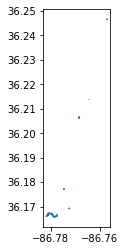

In [37]:
slow_am_school.plot()

<AxesSubplot:>

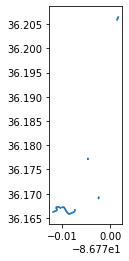

In [38]:
slow_am_summer.plot()

In [39]:
slow_am_sum_geojson = slow_am_summer['geometry'].to_json()

In [40]:
slow_am_scho_geojson = slow_am_school['geometry'].to_json()

In [41]:
full_route = all_am_inschool['geometry'].to_json()

In [42]:
stop_details = inbound23_sts_df.tail(32)
stop_details = stop_details[['geometry', 'stopId', 'stopName', 'averageDwellSeconds']]
stop_details

,geometry,stopId,stopName,averageDwellSeconds
31,POINT (-86.76052 36.24425),DWMRT,Dickerson Rd Wal Mart,NaN
32,POINT (-86.75708 36.24657),DWMRTX,Dickerson Rd Walmart Exit,7.809624
33,POINT (-86.75659 36.24418),DICDOVSN,Dickerson Pike & Doverside Dr Sb,34.003145
34,POINT (-86.75876 36.23278),DICMAPSF,Dickerson Pike & Maplewood Trace Sb,15.138651
35,POINT (-86.75944 36.22873),DICEWISF,Dickerson Pike & Ewing Dr Sb,34.804831
36,POINT (-86.76032 36.22565),DICHILSF,Dickerson Pike & Hillhurst Dr Sb,3.804833
37,POINT (-86.76116 36.22325),DICSUNSN,Dickerson Pike & Sunset Cr Sb,15.311746
38,POINT (-86.76185 36.22131),DICPINSN,Dickerson Pike & Pine Ridge Dr Sb,14.294938
39,POINT (-86.76254 36.21935),DICALHSF,Dickerson Pike & Alhambra Cir Sb,3.392340
40,POINT (-86.76310 36.21775),DICLORSN,Dickerson Pk & Lorraine Ave Sb,4.371383


In [43]:
stop_details.loc[31, 'geometry'].x

-86.76052

In [44]:
stop_geojson = stop_details['geometry'].to_json()

In [45]:
am23_map = folium.Map(location =  [36.2, -86.7775], zoom_start = 12)

style3 = {'color': 'gray', 'weight' : 1}
folium.GeoJson(full_route, style_function=lambda x: style3).add_to(am23_map)

style1 = {'color': 'red', 'weight' : 6}
folium.GeoJson(slow_am_scho_geojson, style_function=lambda x: style1).add_to(am23_map)

style2 = {'color': 'blue', 'weight' : 3}
folium.GeoJson(slow_am_sum_geojson, style_function=lambda x: style2).add_to(am23_map)

for row_index, row_values in stop_details.iterrows():
    loc = [row_values['geometry'].y, row_values['geometry'].x]
    pop = str(row_values['stopName'])
    icon= folium.Icon(color="gray",icon="bus", prefix='fa')
    
    marker = folium.Marker(
        location = loc, 
        popup = pop, 
        icon = icon) 

    marker.add_to(am23_map)
    
am23_map

In [46]:
import pickle

#with open('../data/route23_stop_details.pickle', 'wb') as file:
#    pickle.dump(stop_details, file)

In [47]:
#with open('../data/route23_full_route.pickle', 'wb') as file:
#    pickle.dump(all_am_inschool, file)

In [48]:
#with open('../data/route23_slow_am_school_inbound.pickle', 'wb') as file:
#    pickle.dump(slow_am_school, file)

In [49]:
#with open('../data/route23_slow_am_summer_inbound.pickle', 'wb') as file:
#        pickle.dump(slow_am_summer, file)

In [52]:
stsparams = {
    'direction': '0',
    'startDate': '04-01-2022',
    'endDate' : '04-30-2022',
    'format' : 'geojson',
}

In [53]:
outbound23_sts_df = gpd.GeoDataFrame.from_features(requests.get(URL, params = stsparams, headers = headers).json()['features'])

In [54]:
outbound23_sts_df

,geometry,fromStopId,fromStopName,fromStopLoc,toStopId,toStopName,toStopLoc,pathLengthMeters,averageTravelSeconds,averageTravelSpeed,numTrips,stopId,stopName,averageDwellSeconds
0,"LINESTRING (-86.78139 36.16673, -86.78106 36.1...",MCC4_24,Central 4th Ave - Bay 24,"{'lat': 36.16673, 'lon': -86.78139}",UNI2AEF,Union St & 2nd Ave Eb,"{'lat': 36.16603, 'lon': -86.77741}",523.5,139.660694,3.748370,1769.0,NaN,NaN,NaN
1,"LINESTRING (-86.77741 36.16603, -86.77714 36.1...",UNI2AEF,Union St & 2nd Ave Eb,"{'lat': 36.16603, 'lon': -86.77741}",1SWOONM,S 1st St & Woodland St Nb,"{'lat': 36.16964, 'lon': -86.77241}",684.0,86.893871,7.871671,1769.0,NaN,NaN,NaN
2,"LINESTRING (-86.77241 36.16964, -86.77359 36.1...",1SWOONM,S 1st St & Woodland St Nb,"{'lat': 36.16964, 'lon': -86.77241}",1SJAMNM,N 1st St & James Robertson Pkwy Nb,"{'lat': 36.17264, 'lon': -86.77377}",356.5,24.236337,14.709319,1769.0,NaN,NaN,NaN
3,"LINESTRING (-86.77377 36.17264, -86.77428 36.1...",1SJAMNM,N 1st St & James Robertson Pkwy Nb,"{'lat': 36.17264, 'lon': -86.77377}",N1SOLDNM,N 1st St & Oldham St Nb,"{'lat': 36.17544, 'lon': -86.77428}",314.3,27.821690,11.296941,1769.0,NaN,NaN,NaN
4,"LINESTRING (-86.77428 36.17544, -86.77446 36.1...",N1SOLDNM,N 1st St & Oldham St Nb,"{'lat': 36.17544, 'lon': -86.77428}",DICGRANN,Dickerson Pike & Grace St Nb,"{'lat': 36.18305, 'lon': -86.77376}",855.6,121.516526,7.041018,1769.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,POINT (-86.76987 36.24623),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1121.0,BRICHEEM,Brickmont Ct & Chesapeake Dr Eb,8.120979
125,POINT (-86.76897 36.24545),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1121.0,BRICHEEN,Brickmont Dr & Chesapeake Dr Eb,17.849378
126,POINT (-86.76778 36.24481),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1121.0,CHEWOOSN,Chesapeake Dr & Wood Trl Sb,7.417731
127,POINT (-86.76765 36.24322),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1121.0,CHERAISN,Chesapeake Dr & Rainwood Dr Sb,6.658974


In [55]:
with open('../data/outbound23_sts_df.pickle', 'wb') as file:
        pickle.dump(outbound23_sts_df, file)